In [92]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder

In [65]:
df_attributes=pd.read_csv("datasets/RunningShoes_Challenge/data/runner_attributes.csv")
df_time=pd.read_csv("datasets/RunningShoes_Challenge/data/marathon_times.csv")
#checked for dimension, checked what we see in duplicates

[20 30 35 45 40 50 55 15 60 65 70 75 80]
(92,) ['KEN' 'ETH' 'AUS' 'BRA' 'KOR' 'JPN' 'GBR' 'USA' 'ITA' 'ISR' 'FRA' 'EST'
 'DEU' 'CHE' 'ZAF' 'FIN' 'NOR' 'DNK' 'ESP' 'BEL' 'HUN' 'SWE' 'NLD' 'AUT'
 'EGY' 'RUS' 'CAN' 'POL' 'ISL' 'MLT' 'IRL' 'GAN' 'VEN' 'PRT' 'MEX' 'SVN'
 'AGO' 'CHL' 'LUX' 'DZA' 'LIE' 'CZE' 'CRI' 'TUR' 'KZK' 'IND' 'NZL' 'HRV'
 'ECU' 'BGR' 'GRC' 'CUB' 'PER' 'SLV' 'YUG' 'NIC' 'COL' 'MAR' 'MKO' 'COM'
 'IRN' 'PRI' 'SGP' 'DOM' 'BOL' 'LBR' 'SEN' 'ARG' 'GHA' 'LBN' 'BIH' 'LVA'
 'ALB' 'LTU' 'ISI' 'PAK' 'AFG' 'MUS' 'SVK' 'CHN' 'TWN' 'MLI' 'CYP' 'AHO'
 'ROU' 'IDN' 'BLR' 'FLK' 'THA' 'SDN' 'NGA' 'PHL']
test shapes (30368, 4) (30368,)


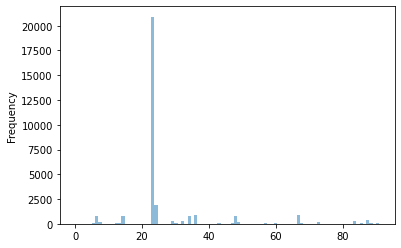

In [101]:
df_merged=df_attributes.join(df_time, lsuffix='_attr', rsuffix='_tim')
#df_merged=df_merged.drop([df_merged.columns[0]], axis='columns')
df_merged.to_csv('df_test.csv')
#print(df_merged.head())
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
df_merged.to_csv('df_merged_attributes_time_nodrop.csv')
#do opposite selection JUST to be sure
df_merged['unique_id'] = np.where((df_merged['unique_id_attr'] == df_merged['unique_id_tim'])
                     , df_merged['unique_id_attr'], np.NaN)
#drop columns for times
df_merged=df_merged.drop(columns=['unique_id_attr', 'unique_id_tim'])
df_merged=df_merged.dropna(axis=0)
df_merged=df_merged[df_merged['netTime']!=-1000]
df_merged.shape
df_merged.treatment.replace(['Treatment', 'Control'], [1, 0], inplace=True)
df_merged.ageClass.replace(['U20'], [15], inplace=True)
df_merged.sex.replace(['M', 'W'], [0, 1], inplace=True)
df_merged.to_csv('df_merged_after_transform.csv')
df_merged['ageClass']=df_merged['ageClass'].astype(int)
#df_merged.plot.bar()
ageClass_values=df_merged['ageClass'].unique()
print(ageClass_values)
nationalities=df_merged['nationality'].unique()
print(nationalities.shape,nationalities)
le = LabelEncoder()
df_merged['nationality']=le.fit_transform(df_merged['nationality'])
#transformed_data = nations_encoder.transform(df_variables['nationality'])
#onehotenc_df = pd.DataFrame(transformed_data)
#data_new = pd.concat([df_variables, onehotenc_df], axis=1).drop(['nationality'], axis=1)
#df_variables.to_csv('data_new.csv')
df_merged['nationality'].plot.hist(bins=92,alpha=0.5)
#df_X_input=df_merged[['ageClass','sex','nationality']]
df_X_input=df_merged[['ageClass','sex','treatment','nationality']]
df_time_values=df_merged['netTime']
df_merged.to_csv('df_test2.csv')
print("test shapes",df_X_input.shape,df_time_values.shape)
X, y = np.arange(10000).reshape((100, 100)), range(100)
split_value=0.25
X_train, X_test, y_train, y_test = train_test_split(df_X_input, df_time_values, test_size=split_value)

Use now scatter plot to find some correlations:

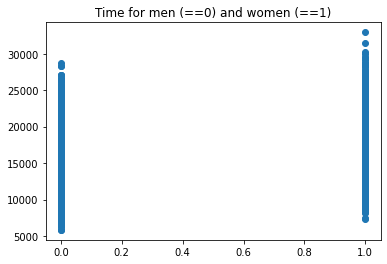

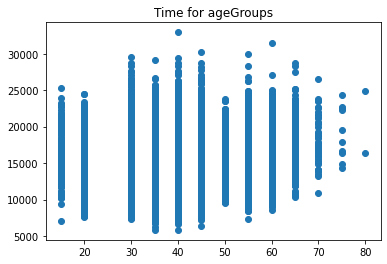

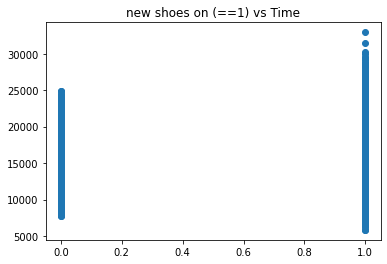

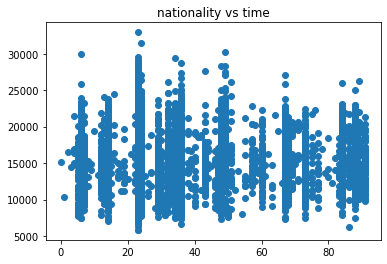

In [102]:
plt.scatter(df_merged["sex"],df_merged["netTime"])
plt.title("Time for men (==0) and women (==1)")
plt.show()
plt.scatter(df_merged["ageClass"],df_merged["netTime"])
plt.title("Time for ageGroups")
plt.show()
plt.scatter(df_merged["treatment"],df_merged["netTime"])
plt.title("new shoes on (==1) vs Time")
plt.show()
plt.scatter(df_merged["nationality"],df_merged["netTime"])
plt.title("nationality vs time")
plt.show()

We already found out the new shoes (treatment) did have the participants with longest times in. On average men are faster than women, for age groups above 50 times rise quite a bit, we also see larger statistics in age groups around 40 before, so tails can also be larger there. For nationalities

[0]	validation_0-rmse:13912	validation_1-rmse:13869.1
[1]	validation_0-rmse:12576.3	validation_1-rmse:12534.3
[2]	validation_0-rmse:11379.9	validation_1-rmse:11338.6
[3]	validation_0-rmse:10309.4	validation_1-rmse:10269.3
[4]	validation_0-rmse:9352.83	validation_1-rmse:9313.85
[5]	validation_0-rmse:8499.17	validation_1-rmse:8461.45
[6]	validation_0-rmse:7738.86	validation_1-rmse:7702.69
[7]	validation_0-rmse:7063.03	validation_1-rmse:7029.24
[8]	validation_0-rmse:6463.76	validation_1-rmse:6432.49
[9]	validation_0-rmse:5933.99	validation_1-rmse:5905.6
[10]	validation_0-rmse:5467.05	validation_1-rmse:5441.5
[11]	validation_0-rmse:5057.24	validation_1-rmse:5034.92
[12]	validation_0-rmse:4698.91	validation_1-rmse:4680.11
[13]	validation_0-rmse:4387.05	validation_1-rmse:4371.52
[14]	validation_0-rmse:4116.89	validation_1-rmse:4105.33
[15]	validation_0-rmse:3884.13	validation_1-rmse:3876.4
[16]	validation_0-rmse:3684.67	validation_1-rmse:3680.74
[17]	validation_0-rmse:3514.62	validation_1-rm

rms train,test linear model 2644.4274081229087 2717.370562346822
R2 score train,test linear model -4.4548178924167114 -4.863742333223596


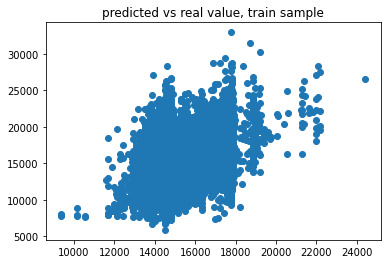

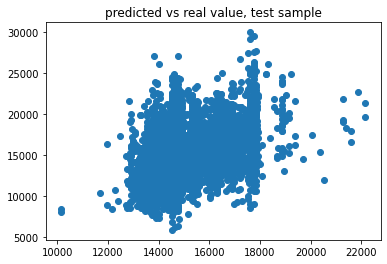

Training score:  0.1661820700640757
Mean cross-validation score: 0.14


ValueError: x and y must have same first dimension, but have shapes (100,) and (7592,)

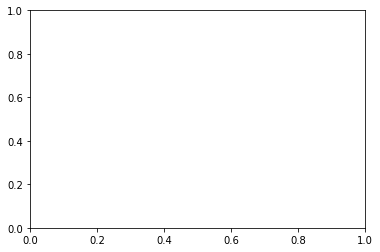

In [107]:
XGB_Model_sklearn =xgb.XGBRegressor()
param_default = {'seed': 7,'base_score': 0.5,'subsample':1,'max_delta_step':0,'max_depth': 5, 'eta': 0.01, 'objective': 'reg:squarederror','nthread':4,'eval_set': [X_test,y_test],
                 'gamma': 0.0, 'min_child_weight': 1.0,'lambda': 1, 'alpha': 0,'subsample':1,
                 'colsample_bytree': 1,'colsample_bylevel':1,'colsample_bynote': 1}
XGB_Model_sklearn.set_params(**param_default)
XGB_Model_sklearn.fit(X_train,y_train,eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='rmse')
#evals_result = XGB_Model_sklearn.evals_result()
print(evals_result)
pred_value_train=XGB_Model_sklearn.predict(X_train)
pred_value_test=XGB_Model_sklearn.predict(X_test)
rms_train=np.sqrt(mean_squared_error(pred_value_train, y_train))
rms_test=np.sqrt(mean_squared_error(pred_value_test, y_test))
r2score_train=r2_score(pred_value_train, y_train)
r2score_test=r2_score(pred_value_test, y_test)
#at least not any overtraining
print("rms train,test linear model",rms_train,rms_test)
print("R2 score train,test linear model",r2score_train,r2score_test)
plt.scatter(pred_value_train,y_train)
plt.title("predicted vs real value, train sample")
plt.show()
plt.scatter(pred_value_test,y_test)
plt.title("predicted vs real value, test sample")
plt.show()
score = XGB_Model_sklearn.score(X_train,y_train)  
print("Training score: ", score)
scores = cross_val_score(XGB_Model_sklearn, X_train, y_train,cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())
x_axis = range(0,100)
plt.plot(x_axis, y_test, label="original")
plt.plot(x_axis, pred_value_test, label="predicted")
plt.legend()
plt.title("predicted and real values for testing dataset")
plt.show()
param_grid = {'max_depth': [4,5,6,7,8,9], 'learning_rate': [0.01,0.05,0.10,0.15,0.20,0.25], 
                    'gamma': [0,0.1,0.2,0.3,0.4], 'min_child_weight': [1,1.5,2,3,5],'reg_lambda':[0.5,1,2,4,6],'reg_alpha':[0,1e-5, 1e-3,1e-2, 0.1, 1, 2,10, 100],
                    'colsample_bytree': [0.5,0.7,0.8,1.0]}

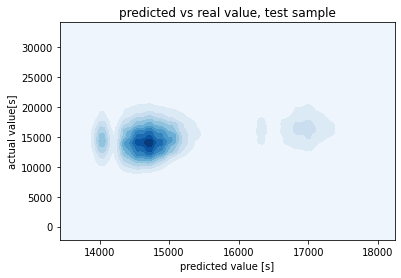

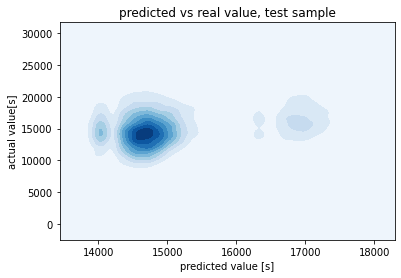

<Figure size 432x288 with 0 Axes>

In [90]:
import seaborn as sns

sbn_fig=sns.kdeplot(pred_value_train, y_train, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Train.eps")
sbn_fig=sns.kdeplot(pred_value_test, y_test, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Test.eps")

rms train,test linear model 2739.954559470894 2776.865311591435
R2 score train,test linear model -7.537215998163939 -7.8596790293194125


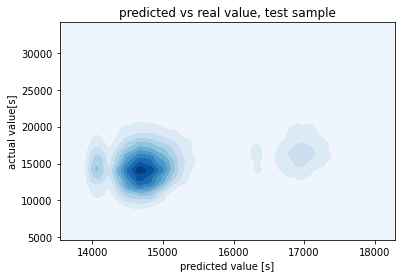

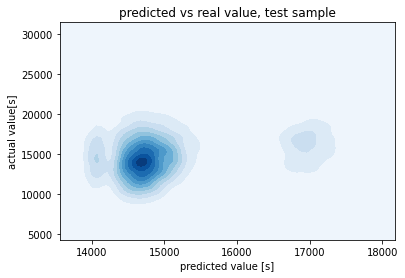

<Figure size 432x288 with 0 Axes>

In [108]:
from sklearn import linear_model

lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
pred_value_train=lr.predict(X_train)
pred_value_test=lr.predict(X_test)
rms_train=np.sqrt(mean_squared_error(pred_value_train, y_train))
rms_test=np.sqrt(mean_squared_error(pred_value_test, y_test))
r2score_train=r2_score(pred_value_train, y_train)
r2score_test=r2_score(pred_value_test, y_test)
#at least not any overtraining
print("rms train,test linear model",rms_train,rms_test)
print("R2 score train,test linear model",r2score_train,r2score_test)
sbn_fig=sns.kdeplot(pred_value_train, y_train, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Train.eps")
sbn_fig=sns.kdeplot(pred_value_test, y_test, cmap="Blues", shade=True, shade_lowest=True, )
plt.title("predicted vs real value, test sample")
plt.xlabel('predicted value [s]')
plt.ylabel('actual value[s]')
plt.show()
plt.savefig("pred_vs_actualValue_Test.eps")

In [120]:
from sklearn.linear_model import Lasso

rms_train_best_cv=100000
R2_train_best_cv=-10
rms_train_best_train=100000
R2_train_best_train=100000
rms_test_best_cv=100000
R2_test_best_train=100000

alpha_rms_best=-10
lasso_parameters = [0.001,0.01,0.02, 0.024, 0.025, 0.026, 0.03,0.05,1.0,1.5]
for alpha_value in lasso_parameters:
    lasso = Lasso(alpha = alpha_value)
    lasso.fit(X_train,y_train)
    y_pred_test = lasso.predict(X_test)
    y_pred_train = lasso.predict(X_train)
    rms_train=np.sqrt(mean_squared_error(pred_value_train, y_train))
    rms_test=np.sqrt(mean_squared_error(pred_value_test, y_test))
    r2score_train=r2_score(pred_value_train, y_train)
    r2score_test=r2_score(pred_value_test, y_test)
    if rms_test<rms_train_best_cv:
        rms_train_best_cv=rms_train
        rms_test_best_cv=rms_test
        alpha_rms_best=alpha_value
        R2_train_best_cv=r2score_train
        R2_test_best_cv=r2score_test
    if rms_train<rms_train_best_train:
        rms_train_best_train=rms_train
        R2_train_best_train=r2score_train
print("alpha RMS/R2",alpha_rms_best)
print("R2 test/train",R2_test_best_cv,R2_train_best_cv,R2_train_best_train)
print("rms test/train",rms_test_best_cv,rms_train_best_cv,rms_train_best_train)

rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
rms_train 2739.954559470894
alpha RMS/R2 0.001
R2 test/train -7.8596790293194125 -7.537215998163939 -7.537215998163939
rms test/train 2776.865311591435 2739.954559470894 2739.954559470894


Maybe not done perfectly but different methods used:

|Regression Model used|RMS Train predictions|RMS Test Predictions|
|---------------------|---------------------|--------------------|
|Linear Regression    |2762                 |2740                |
|XGBoost              |2677                 |2679                |

In [97]:
from sklearn.linear_model import LogisticRegression

lr = linear_model.LogisticRegression()
lr.fit(X_train,y_train)
pred_value_train=lr.predict(X_train)
pred_value_test=lr.predict(X_test)
rms_train=np.sqrt(mean_squared_error(pred_value_train, y_train))
rms_test=np.sqrt(mean_squared_error(pred_value_test, y_test))
r2score_train=r2_score(pred_value_train, y_train)
r2score_test=r2_score(pred_value_test, y_test)
print("rms train,test linear model",rms_train,rms_test)
print("R2 score train,test linear model",r2score_train,r2score_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


rms train,test linear model 3224.5901318487104 3234.534577591004
R2 score train,test linear model -2.667163808817296 -2.696679157584411
